In [3]:
import numpy as np

import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
%load_ext line_profiler

In [67]:
def simulate_bites(y,eir):
    '''
    Produces a vector with bite times up until year, y, is reached.

    Time between bites pulled from exponential distribution wih mean rate of k = eir/365.
    '''
    k = eir/365
    n = round(y*eir*2)
    spaces = st.expon.rvs(scale=(1/k), loc=0, size=n)
    times = np.cumsum(spaces)
    trimmed = times[times <= y*365]
    bites = np.ceil(trimmed).astype(int)
    return bites

def simulate_genotypes(n,a):
    '''
    n = number of strains to simulate
    a = vector whose length corresponds to number of loci.
    Each entry corresponds to the number of alleles at that loci.
    so a = [3,4,6] will simulate a strain with 3 loci. The first
    loci has 3 alleles; the second loci has 4 alleles, and the third
    loci has 6 alleles.

    Returns genotype as a L x n matrix, where L = the number of loci.
    '''
    length = len(a)
    M = np.empty((length,n),dtype=int)
    for i in range(n):
        floats = np.random.rand(length) # Currently only simulates things from uniform distribution
        genotype = np.ceil(floats*a)-1 # Current only simulates things ffrom uniform distribution
        M[:,i] = genotype
    return M

def get_mz(meroz=0.8): ### Work here
    '''
    Generates starting number of merozoites from a lognormal distribution. 
    Values from here: https://www.science.org/doi/10.1126/scitranslmed.aag2490
    '''
    mz = st.lognorm.rvs(s=1,scale=meroz)
    return mz

def get_r(growthrate=1.2):
    '''
    Generates r from normal distribution.
    Values from here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7198127/
    '''
    r = st.norm.rvs(loc = growthrate, scale=0.1)
    return r

def simulate_params(n,meroz,growthrate):
    '''
    Simulates mz and growth rate for strains.
    Returns 2 x n matrix.
    
    Inputs:
        n = number of strains
        meroz = average starting number of merozites
        growthrate = average starting growthrate
    '''
    M = np.zeros((2,n))
    for i in np.arange(n):
        M[0,i] = get_mz(meroz)
        M[1,i] = get_r(growthrate)
    return M
    
def create_allele_matrix(a,y):
    '''
    Creates matrix to track parasitemia.
    '''
    length = len(a)
    width = max(a)
    days = 365*y
    M = np.zeros((length,width,days))
    return M

def create_strain_matrix(n,y):
    '''
    Creates n x y*365 matrix to track strains presence per day.
    '''
    M = np.zeros((n,y*365))
    return M

def add_infection(t,j,mz,gtype,sM,pM,iM,y):
    '''
    Adds infection to strain & parasite matrices. Also adds immunity 14 days later.
    
    Inputs:
        t = time in days
        j = bite number
        mz = start of merozites
        gtype = genotype of infection
        sM = matrix tracking parasitemia by strain
        pM = matrix tracking parasitemia by allele
        iM = matrix tracking immunity by allele
    '''
    sM[j,t] = mz
    for locus, allele in enumerate(gtype): # Might be able to speed up with vectorization here
        pM[locus, allele,t] = mz
        if t+14 < y*365:
            iM[locus,allele,t+14:] = 1
        
def update_immunity(t,locus,allele,pM,iM,gamma=-0.002): # Use with np.vectorize()
    '''
    Immunity exponentially decays if parasite not present.
    
    Inputs:
        t = time in days
        locus = locus number 
        allele = allele number
        pM = matrix tracking parasitemia by allele
        iM = matarix tracking immunity by allele
        gamma = rate of decay
    '''
    if pM[locus,allele,t] == 0 and iM[locus,allele,t-1] != 0:
        iM[locus,allele,t] = iM[locus,allele,t-1]*np.exp(gamma)
    
def get_strain_immunity(gtype,i2,w):
    '''
    Returns immunity to strain.
    gtype = genotype of strain
    i2 = immune matrix at t of interest.
    w = vector weighting immunity by allele
    '''
    n_loci = len(gtype)
    cross = np.empty(n_loci)
    for i in np.arange(n_loci): ## Could try to vectorize; might speed up.
        allele = gtype[i]
        cross[i] = i2[i,allele]
    imm = (cross*np.asarray(w)).sum()
    return imm

def modulate_growth_rate(imm,r0,rend=-0.05,xh=0.3, b=-2):
    '''
    Modulates growth rate based on immunity.
    '''
    if imm == 0:
        return r0
    else:
        c = np.tan(np.pi/2*xh)**b
        r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend
    return r
    
def update_parasitemia(t,j,w,gM,iM,rV,sM,pM,k = 5*10**5,rend=-0.05,xh=0.3,b=-2,pgone=0.001): # vectorize across J
    '''
    Updates parasitemia for each strain and allele by bite number.
    
    Inputs:
        t = time in days
        j = bite number
        w = vector weighting immunity by allele
        gM = genotype matrix
        iM = immune matrix
        rV = vector tracking initial growth rate by bite number.
        sM = matrix tracking parasitemia by strain
        pM = matrix tracking parasitemia by allele
        k = carrying capacity
        rend = growth rate with 100% immunity
        xh = param scaling immunity's impact on growth rate
        b = param scaling immunity's impact on growth rate
        pgone = threshold below which infection goes to zero
    '''
    done = set()
    imm = get_strain_immunity(gM[:,j],iM[:,:,t-1],w)
    r = modulate_growth_rate(imm,rV[j],rend,xh,b)
    
    if sM[j,t] == 0:
        p0 = sM[j,t-1]
        if p0 != 0:
            if r > 0:
                p = k/(1+((k-p0)/p0)*np.exp(-r))
            else:
                p = p0*np.exp(r)
                if p < pgone:
                    p = 0
                    done.add(j)
        else:
            p = 0
        
        sM[j,t] = p
        
        for loci, allele in enumerate(gM[:,j]): # Might be able to speed up with vectorization here
            pM[loci, allele,t] += p
    return done
            
def get_fever_threshold(t, eir,fever,breaks):
    '''
    Pulls fever threshold from model used in ["Quantification of anti-parasite and anti-disease immunity to malaria as a function of age and exposure"](https://elifesciences.org/articles/35832).
    
    Inputs:
        t = time in days
        eir = entomologic inoculation rate
        fever = loaded numpy data from paper
        breaks = loaded numpy data from paper
    '''
    age_loc = np.flatnonzero(breaks[:,0]>=t/365)[0]
    eir_loc = np.flatnonzero(breaks[:,2]>=eir)[0]
    pardens_loc = np.flatnonzero(fever[age_loc,:,eir_loc])[0]
    thresh = breaks[pardens_loc,1]
    return 10**thresh
    
def treat_malaria(t, threshhold, pM, sM, m,a):
    '''
    Treat if parasitemia goes above certain threshold. Modifies parasite density
    matrix & strain matrix. Returns updated list with days malaria has occured.
        threshold = threshold for treatment
        pM = matrix tracking parasite density by allele across time.
        sM = matrix tracking parasitemia by strain across time.
        m = list with days malaria has occured
    '''
    if pM[0,:,t-1].sum(axis=0) > threshhold:
        pM[:,:,t] = 0
        sM[:,t] = 0
        m.append(t)
        a = set()
    return m,a

def load_data():
    '''
    Loads data used in the model
    '''
    fever = np.load("data/fever.npy")
    breaks = np.load("data/breaks.npy")
    return fever, breaks

def simulate_person(y,eir,a,w,meroz=0.8,growthrate=1.2,k=5*10**5,rend=-0.05,xh=0.3,b=-2,pgone=0.001, gamma=-0.002):
    '''
    Runs simulation for one person. Returns matrix tracking parasitemia by allele, 
    matrix tracking immunity by allele, matrix tracking parasitemia by strain, and
    a list containing the days of every malaria episode someone had.

    Inputs:
        y = years to simulate
        eir = entomological inoculation rate
        a = vector with number of allels per loci
        meroz = average starting number of merozites
        growthrate = average starting growthrate
        w = vector weighting immunity by allele
        k = carrying capacity
        rend = growth rate at 100% immmunity
        xh = param scaling immunity's impact on growth rate
        b = param scaling immunity's impact on growth rate
        pgone = threshold below which infection goes to zero
    '''
    # Simulates bites & strain characteristics
    bites = simulate_bites(y,eir)
    n = len(bites)
    gtypes = simulate_genotypes(n,a)
    params = simulate_params(n,meroz,growthrate)

    # Creates objects to record
    pM = create_allele_matrix(a,y)
    iM = create_allele_matrix(a,y)
    sM = create_strain_matrix(n,y)
    malaria = []
    active = set()
    
    # Runs forward time simulation
    ## Day 0:
    t = 0
    if t in bites: # Case where first bite is on day zero.
        locs = np.where(bites == t)
        for j in locs[0]:
            add_infection(t,j,params[0,j],gtypes[:,j],sM,pM,iM=iM,y=y)
            active.add(j)

    ## Day 1+
    for t in np.arange(1,y*365):
        if t in bites:
            if not len(malaria) > 0 or t - malaria[-1] > 7:
                locs = np.where(bites == t)
                for j in locs[0]:
                    add_infection(t,j,params[0,j],gtypes[:,j],sM,pM,iM=iM,y=y)
                    active.add(j)
        if active:
            for j in active:
                drop = update_parasitemia(t=t,j=j,w=w,gM=gtypes,iM=iM,rV=params[1,:],sM=sM,pM=pM,k=k,rend=rend,xh=xh,b=b,pgone=pgone)
                if drop:
                    active = active.difference(drop)
        thresh = get_fever_threshold(t,eir,fever,breaks)
        malaria,active = treat_malaria(t,thresh,pM,sM,malaria,active)
        for locus in np.arange(len(a)):
            for allele in np.arange(max(a)):
                update_immunity(t=t,locus=locus,allele=allele,pM=pM,iM=iM,gamma=gamma)
    return pM, iM, sM, malaria

In [74]:
y = 3
eir = 40
a = [20,20,20,20]
w = [0,1/3,1/3,1/3]
gamma= -0.035
fever,breaks = load_data()

In [75]:
pmatrix, imatrix, smatrix, malaria = simulate_person(y,eir,a,w,gamma=gamma)

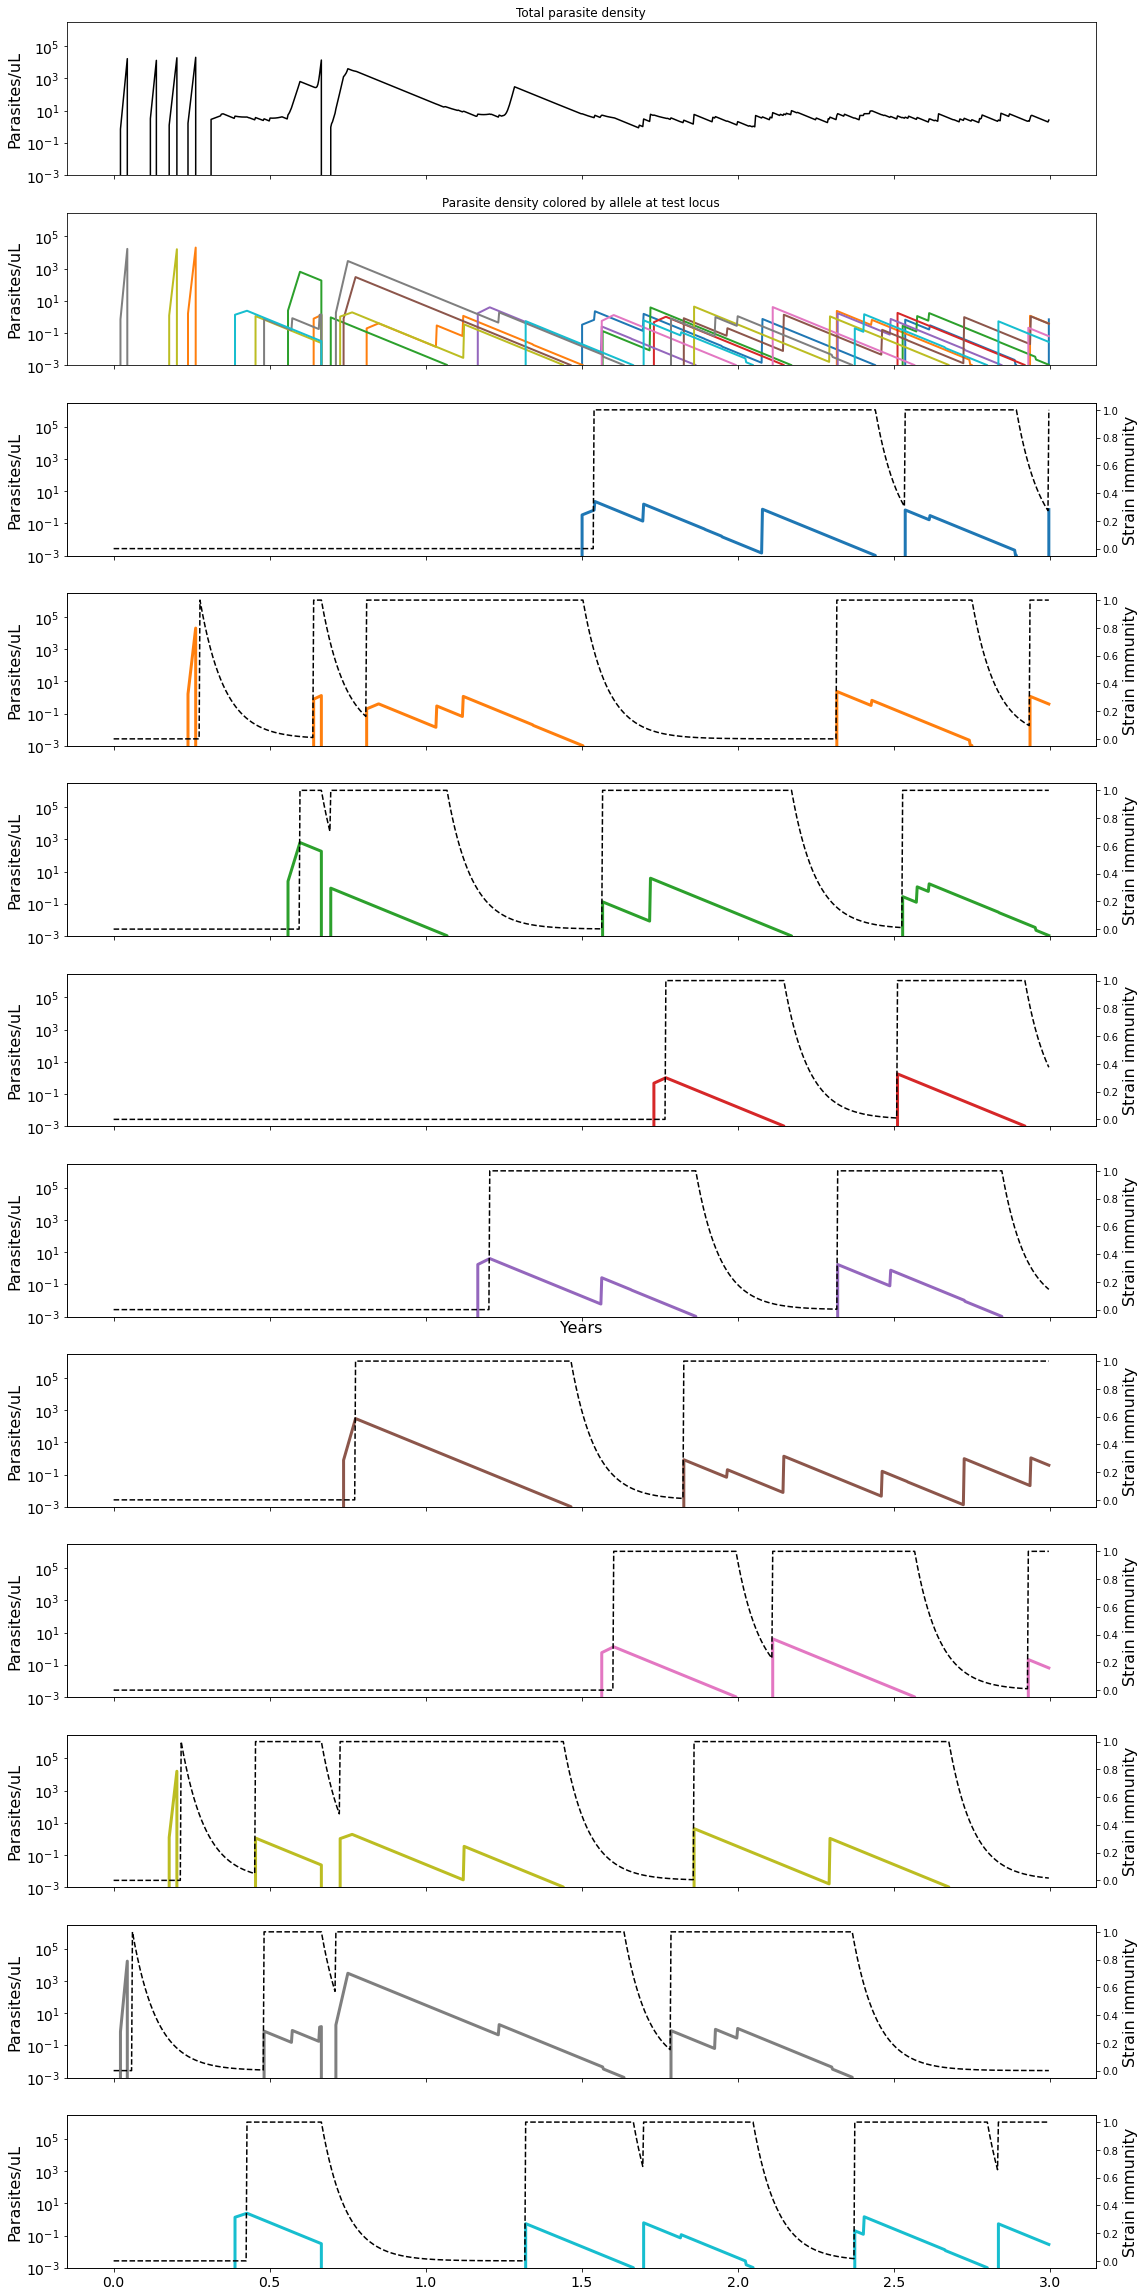

In [76]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[-1,:,:].sum(axis=0),color="black")
for strain in np.arange(10):
    iStrain = pmatrix[-1,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
ax[0].set_ylim(0.001,3000000)
ax[6].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL',fontsize=16)
for row in range(2,12):
    ax[row].tick_params(axis='both', which='major', labelsize=14)
    ax[row].set_ylabel('Parasites/uL',fontsize=16)
    other = [strain for strain in range(0,5) if strain != row-2]
    ax[row].plot(np.arange(y*365)/365, pmatrix[-1,row-2,:],linewidth=3,color=colors[row-2])

    #for strain in other:
     #   ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,strain,:],linewidth=2,alpha=0.2,color=colors[strain])

    ax2 = ax[row].twinx()
    ax2.set_ylabel('Strain immunity',fontsize=16)
    ax2.plot(np.arange(y*365)/365, imatrix[-1,row-2,:],linewidth=1.5,color='black',linestyle='dashed')

In [151]:
def check_moi(y,sM):
    '''
    Returns MOI every 30 days:
        y = years
        sM = matrix tracking strains across time.
    '''
    mois = []
    for t in range(0,y*365,30):
        moi = sM[:,t].sum()
        mois.append(moi)
    return mois

def check_parasitemia(y,pM,detect_thresh=0.001):
    '''
    Returns parasite density every 30 days, and the percent of times (every 30
    days) over the course of the study that someone had parasites.
    '''
    pdensity = []
    ppositivity = []
    for t in range(0,y*365,30):
        p = pM[0,:,t].sum()
        pdensity.append(p)
        if p > detect_thresh:
            ppositivity.append(1)
        else:
            ppositivity.append(0)
    perpos = np.average(ppositivity)
    return pdensity, perpos

def check_infection_length(sM,y, malaria):
    lengths = []
    infections = len(sM)
    for i in range(infections):
        counter = 0
        for j in range(y*365):
            if sM[i,j] == 1:
                counter += 1
                if j in malaria:
                    counter = 0
        if counter > 0:
            lengths.append(counter)
    return lengths

Text(0.5, 0, 'Initial growth rate')

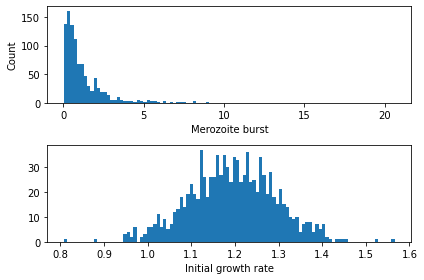

In [77]:
params = np.zeros((2,1000))

for i in np.arange(1000):
    params[0,i] = get_mz(0.8)
    params[1,i] = get_r(1.2)
    
fig,ax = plt.subplots(nrows=2, tight_layout = True)
ax[0].hist(params[0,:],bins=100)
#ax[1].hist(np.exp(params[1,:]*2),bins=100)
ax[1].hist(params[1,:],bins=100)
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Count")
ax[0].set_xlabel("Merozoite burst")
ax[1].set_xlabel("Initial growth rate")
#fig.savefig("figs/starting_params.pdf")

In [59]:
params[0,:].min()

0.02230794180905252

In [169]:
def growth_rate(imm,param,end=-0.05,xh=0.3, b=-2):
    if imm == 0:
        return param
    else:
        c = np.tan(np.pi/2*xh)**b
        r = (param-end)/(c/np.tan(np.pi/2*imm)**b+1)
    return r + end

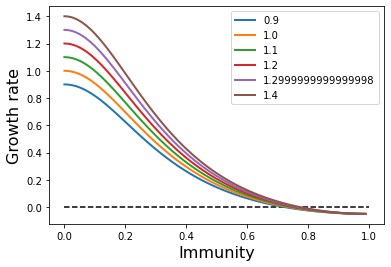

In [175]:
imms = np.arange(0,1,0.01)
rates = np.arange(0.9,1.5,0.1)

ends = np.zeros((len(xhs),len(imms)))

for i,rate in enumerate(rates):
    for j,imm in enumerate(imms):
        ends[i,j] = growth_rate(imm,rate)

fig, ax = plt.subplots()

for i,rate in enumerate(rates):
    ax.plot(imms, ends[i,:], linewidth=2, label = rate)
ax.set_xlabel("Immunity", fontsize=16)
ax.set_ylabel("Growth rate",fontsize=16)
ax.hlines(y=0, xmin = 0, xmax=1,color='k',linestyle='--')
ax.legend()
fig.savefig("figs/r_immunity.pdf")

In [152]:
growth_rate(0.5,1.4)

0.08846267907816312

In [75]:
growth_rate(0.95,1.3)

0.672818057708006